# FA22 A101 Lab 2 Image Processing notebook

Oct 10, 2022

@Pei Qin / @pchoi
Ideally this notebook wants to be run from a python 3.8 environment/kernal.

If your astroconda python <3.7 then create a new environment in the UNIX shell:
```
$ conda create -n astroconda38 python=3.8
$ conda activate astroconda38
$ conda install -c astropy ccdproc photutils ipywidgets matplotlib pandas
```

if you can't find the module 'photutils'
```
%pip install photutils
```

In [1]:
### Some imports for photometry & plotting

# imports
import pandas as pd

import os
import glob

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

from astropy.visualization import ZScaleInterval
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits
from astropy import stats
from astropy.table import QTable, vstack

import numpy as np

from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry, ApertureStats
from photutils.detection import DAOStarFinder

from pathlib import Path


In [5]:
### Some helper functions for reading in multiple images:

'''
helper function
args:
    data_dir = path to directory of images for slicing in string representation
    file_matching = pattern matching for file name
    contain_dir = boolean, whether to include relative path to the directory, or only keep the filename
    save_ls = boolean, whether to save the list as a .txt file
    save_name = name of the saved list, e.g. 'all_bias.txt'
output: saves a .txt file of all the matching filenames + returns a list of filenames
'''
def findAllIn(data_dir, file_matching, contain_dir=False, save_ls=True, save_name=None):
    if save_name == None:
        save_name = 'all_' + file_matching + '.txt'
    list_files = glob.glob(os.path.join(data_dir, file_matching))
    if not contain_dir:
        list_files[:] = (os.path.basename(i) for i in list_files)
    if save_ls:
        with open(data_dir + save_name, "w") as output:
            for i in list_files:
                output.write(str(i) + '\n')
    return list_files


def read_fits_ls(ls_toOp, data_dir, return_ls = False):
    if isinstance(ls_toOp, str):
        input_ls = pd.read_csv(ls_toOp, header = None)
        ls = input_ls[0]
    else:
        ls = ls_toOp
    toOp = []
    for i in ls:
        f = fits.open(Path(os.path.join(data_dir + i)))
        toOp.append(f)
    toReturn = toOp
    if return_ls:
        toReturn = (toOp, ls)
    return toReturn

'''
for closing the read-in fits list once all operations are done
'''
def close_fits_ls(ls):
    for i in ls:
        i.close()

In [17]:
### Let's define some variables that will be used throughout the notebook:

## Source detection variables
_DETECTION_IMAGE_PATH='./combined_star1_filtAll.fits'
_DETECTION_SIGMA=5.0
_STELLAR_FWHM=13 # Pixels)
_NN=35  # Number of sources to keep from the sources list

_PHOT_ZP=25

## DEFINE THE DEFAULT APERTURE & ANNULUS VALUES FOR VISUALIZATION
_NN_ap_radius = 3.0 # In units of Half-width half-max (Since radius not diameter)
_NN_ann_radius_inner = 5.0  # In units of Half-width half-max (Since radius not diameter)
_NN_ann_radius_outer = 9.0  # In units of Half-width half-max (Since radius not diameter)


## Multiple Aperture Variable:
## Define the set of Radii used for Multiple Aperture Photometry
#_radii = [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5]
#_radii = [0.5,1,2,3,4,5]
_radii = [2,3,4]

#Multiple images variables
_BATCH_IMAGES_PATH='./alipy_out/'
_BATCH_IMAGES='*fdb_*.fits'

## Source detection (on a detection image)

Good job on getting the calibrated and aligned data! Now we need to extract sources from a detection image (combined image or reference image).

If you have done this step and have a list of detected sources already, feel free to skip to Photometry directly.

In [10]:
# Reminder:  Your path wants to be with respsect to the location of your ipynb file.
hdu = fits.open(Path(_DETECTION_IMAGE_PATH))
ref_detect = hdu[0].data
ref_detect_header = hdu[0].header
hdu.close()

(<Figure size 600x600 with 1 Axes>, <AxesSubplot:>)

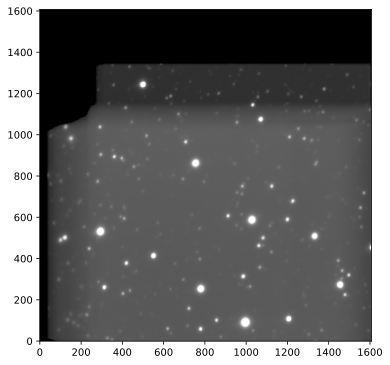

In [11]:
# helper function
def show_img(img, title=None):
    norm = ImageNormalize(img, interval=ZScaleInterval(nsamples=600, contrast=0.25))

    fig, ax = plt.subplots()
    fig.set_size_inches(6,6)
    ax.imshow(img, cmap='Greys_r', origin='lower', norm=norm)
    if title != None:
        ax.set_title(title, fontsize=20)
    # ax.tick_params(labelsize='large', width=1)

    return (fig, ax)
    
show_img(ref_detect)

In [18]:
img = ref_detect
img_header = ref_detect_header

# get stats for setting detection threshold
stars_mean, stars_med, stars_sd = stats.sigma_clipped_stats(img, sigma=3.0, maxiters=3, std_ddof=1)
print("mean, median, standard deviation: %5.3f / %5.3f / %5.3f" % (stars_mean, stars_med, stars_sd))

# extracting sources based on stats
daofind = DAOStarFinder(fwhm=_STELLAR_FWHM, threshold=_DETECTION_SIGMA*stars_sd) # you can change the fwhm based on an estimate from imexam()
sp_all = daofind(img - stars_med)
sp_all.sort('flux', reverse=True)

# display source list (we'll talk more about the pandas DataFrame later when saving the source tables)
sp_all

mean, median, standard deviation: 29.003 / 38.279 / 16.474


id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
4,996.1966317715764,90.65641931993585,0.4102248689055406,0.18974126205341274,0.23939883000629616,289,0.0,2853.4867788188762,102.39006927377268,-5.025644592069614
32,1028.056445071795,586.1993934683582,0.3956278527038643,0.227601600395222,0.20728691357499324,289,0.0,1272.5224068000996,45.754389991304016,-4.151081924013397
31,293.8342176130546,530.1489009113219,0.4357280457615518,0.22977356799739818,0.19586881752689653,289,0.0,1503.6555583255354,42.2189185852108,-4.063767762238989
12,780.2371221438343,253.0667222956538,0.4010393945732908,0.21951300556932607,0.24766097647580732,289,0.0,1059.8078313152419,38.498603916005415,-3.9636124521759006
72,499.98967752677294,1240.6078798873386,0.3744946407813729,0.27004075054102944,0.17492814598074777,289,0.0,949.4117986973524,34.94466772357935,-3.8584522881941585
45,755.0411743142649,860.2870520140573,0.429863254654749,0.22694150914220648,0.14507734882747264,289,0.0,1033.024448297366,30.684038224525406,-3.7172812877375434
15,1455.376921208935,272.9430827074989,0.4178494078192081,0.08573512916041995,0.13298318967840758,289,0.0,695.931429154584,19.717175035540652,-3.237111729560485
30,1331.8860183365216,507.8253437269387,0.3994667310122315,0.19136882189530938,0.1734600972119143,289,0.0,538.5875492880032,18.48576388306143,-3.167093503832712
61,1070.4313810374633,1072.9412499867656,0.3956928839273428,0.2595250176564973,0.1489249436398202,289,0.0,284.3160809275183,10.555026323418176,-2.5586483018545705


In [19]:
# keeping only the _NN brightest sources:
sp = sp_all[:_NN]
sp

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
4,996.1966317715764,90.65641931993585,0.4102248689055406,0.18974126205341274,0.23939883000629616,289,0.0,2853.4867788188762,102.39006927377268,-5.025644592069614
32,1028.056445071795,586.1993934683582,0.3956278527038643,0.227601600395222,0.20728691357499324,289,0.0,1272.5224068000996,45.754389991304016,-4.151081924013397
31,293.8342176130546,530.1489009113219,0.4357280457615518,0.22977356799739818,0.19586881752689653,289,0.0,1503.6555583255354,42.2189185852108,-4.063767762238989
12,780.2371221438343,253.0667222956538,0.4010393945732908,0.21951300556932607,0.24766097647580732,289,0.0,1059.8078313152419,38.498603916005415,-3.9636124521759006
72,499.98967752677294,1240.6078798873386,0.3744946407813729,0.27004075054102944,0.17492814598074777,289,0.0,949.4117986973524,34.94466772357935,-3.8584522881941585
45,755.0411743142649,860.2870520140573,0.429863254654749,0.22694150914220648,0.14507734882747264,289,0.0,1033.024448297366,30.684038224525406,-3.7172812877375434
15,1455.376921208935,272.9430827074989,0.4178494078192081,0.08573512916041995,0.13298318967840758,289,0.0,695.931429154584,19.717175035540652,-3.237111729560485
30,1331.8860183365216,507.8253437269387,0.3994667310122315,0.19136882189530938,0.1734600972119143,289,0.0,538.5875492880032,18.48576388306143,-3.167093503832712
61,1070.4313810374633,1072.9412499867656,0.3956928839273428,0.2595250176564973,0.1489249436398202,289,0.0,284.3160809275183,10.555026323418176,-2.5586483018545705


## Photometry

### Now we are ready to tackle the last step: getting a magnitude value from your science image.

**Make sure you are running the notebook from a python3.8 or above environment!**

In [ ]:
# If NOT using the sources list created above, then uncomment the lines below to read in an alternate source list:
# sp = pd.read_csv('./Source_List.csv')
# sp

In [20]:
# Read in combined image for SINGLE-FRAME Photometry (yes this is redunant):
hdu = fits.open(Path(_DETECTION_IMAGE_PATH))
ref_detect = hdu[0].data
ref_detect_header = hdu[0].header
hdu.close()

In [21]:
# defining sources & x, y coordinate column names
sources = sp
x_colname = 'xcentroid'
y_colname = 'ycentroid'
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
4,996.1966317715764,90.65641931993585,0.4102248689055406,0.18974126205341274,0.23939883000629616,289,0.0,2853.4867788188762,102.39006927377268,-5.025644592069614
32,1028.056445071795,586.1993934683582,0.3956278527038643,0.227601600395222,0.20728691357499324,289,0.0,1272.5224068000996,45.754389991304016,-4.151081924013397
31,293.8342176130546,530.1489009113219,0.4357280457615518,0.22977356799739818,0.19586881752689653,289,0.0,1503.6555583255354,42.2189185852108,-4.063767762238989
12,780.2371221438343,253.0667222956538,0.4010393945732908,0.21951300556932607,0.24766097647580732,289,0.0,1059.8078313152419,38.498603916005415,-3.9636124521759006
72,499.98967752677294,1240.6078798873386,0.3744946407813729,0.27004075054102944,0.17492814598074777,289,0.0,949.4117986973524,34.94466772357935,-3.8584522881941585
45,755.0411743142649,860.2870520140573,0.429863254654749,0.22694150914220648,0.14507734882747264,289,0.0,1033.024448297366,30.684038224525406,-3.7172812877375434
15,1455.376921208935,272.9430827074989,0.4178494078192081,0.08573512916041995,0.13298318967840758,289,0.0,695.931429154584,19.717175035540652,-3.237111729560485
30,1331.8860183365216,507.8253437269387,0.3994667310122315,0.19136882189530938,0.1734600972119143,289,0.0,538.5875492880032,18.48576388306143,-3.167093503832712
61,1070.4313810374633,1072.9412499867656,0.3956928839273428,0.2595250176564973,0.1489249436398202,289,0.0,284.3160809275183,10.555026323418176,-2.5586483018545705


In [22]:
# Define individual aperture width. Usually it is 3~4 times the fwhm of your targets.

# First define the image FWHM in pixels (nb for TMO/Photometrics pixel scale is ~0.25"/pixel)
img_fwhm = _STELLAR_FWHM
ZeroPt = _PHOT_ZP # This is an arbitrary magnitude offset for now.

## Aperture and Annulus sizes are defined according to the _NN_ap_radius and _NN_ann_radius values above.
ap_radius = _NN_ap_radius * (img_fwhm/2.0)
print("aperture radius (pixels): %5.3f" % ap_radius)
ann_radius = [(_NN_ann_radius_inner * (img_fwhm/2.0), _NN_ann_radius_outer * (img_fwhm/2.0))]
print("annulus (inner/outer edge) radius (pixels): %5.3f / %5.3f" % (ann_radius[0][0], ann_radius[0][1]))

area_ap=3.14*ap_radius**2
area_ann=3.14*ann_radius[0][1]**2 - 3.14*ann_radius[0][0]**2
print("Aperture vs. annulus area (pixels): %5.3f / %5.3f " % (area_ap, area_ann))

# get positions of sources (in descending order of flux)
positions = []
for i in range(len(sources)):
    positions.append((sources[x_colname][i], sources[y_colname][i]))
#positions

aperture radius (pixels): 19.500
annulus (inner/outer edge) radius (pixels): 32.500 / 58.500
Aperture vs. annulus area (pixels): 1193.985 / 7429.240 


## Aperture/Annulus visualization:  
### It is hard to know if the values above are reasonable, so let's inspect our image and write a DS9 regions file to overlay on a ds9 display for closer inspection.


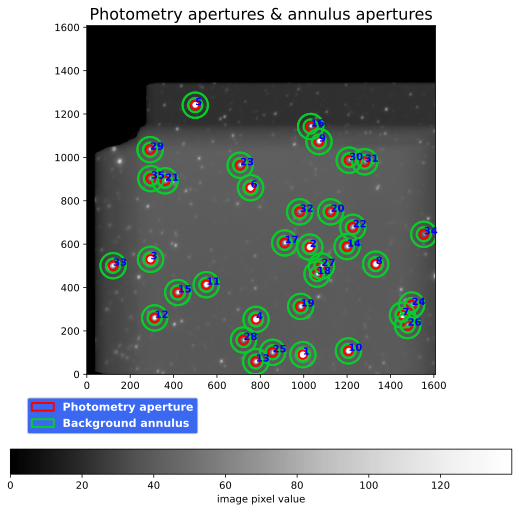

In [23]:
# initializing a list to save apertures and annulus_apertures
apertures = []
annulus_apertures = []

fig, ax = plt.subplots(figsize=(9,9))

norm = ImageNormalize(img, interval=ZScaleInterval(nsamples=600, contrast=0.25))

### brightest -> dimmest = red -> blue
colors = np.arange(0, 1, 1/len(sources))

im = ax.imshow(img, cmap='Greys_r', interpolation='none', origin='lower', norm=norm)

ax.set_title("Photometry apertures & annulus apertures", fontsize=16)

## In addiiton to the plot below, let's make a DS9 REGIONS file that we can overlay on DS9 (Header info)
with open('ds9_apertures.reg', 'w') as f:
    print('# Region file format: DS9 version 4.1', file=f)
    print('global color=green dashlist=8 3 width=1 font=\"helvetica 10 normal roman\" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1', file=f)
    print('physical', file=f)

    for i in range(len(sources)):
        c = colors[i]
        # ap_width = ap_radius*2 # or set equal to a constant here
        circ = plt.Circle((sources[x_colname][i], sources[y_colname][i]), ap_radius,fill=False, color=(1-c,0,c), linewidth=0)
        ax.add_patch(circ)
        # aperture
        ap = CircularAperture(positions[i], r=ap_radius)
        apertures.append(ap)
        ap.plot(color='red', lw=1, label='Photometry aperture')
        # annulus
        ann = CircularAnnulus(positions[i], r_in=ann_radius[0][0], r_out=ann_radius[0][1])
        annulus_apertures.append(ann)
        ann.plot(color='#08cc2a', lw=2, label='Background annulus')
        # number the targets
        num = plt.text(sources[x_colname][i], sources[y_colname][i], i+1, color='blue', fontweight=700)
        
        ## In addiiton to the plot below, let's make a DS9 REGIONS file that we can overlay on DS9 (Apertures and Annuli)
        print("annulus(",positions[i][0],",",positions[i][1],",",ann_radius[0][0],",",ann_radius[0][1],") # color=red", file=f)
        print("circle(",positions[i][0],",",positions[i][1],",",ap_radius,") # color=green  text={",i+1,"}", file=f)

# display limits

#plt.xlim([950,1150])
#plt.ylim([1300,1500])

'''zoomview = 3 # index to the star you want to zoom into
x_lim = [sources[x_colname][zoomview] - 300, sources[x_colname][zoomview] + 300]
y_lim = [sources[y_colname][zoomview] - 300, sources[y_colname][zoomview] + 300]
plt.ylim(y_lim)
plt.xlim(x_lim)'''

# legends
## pic: seems like these two lines are double ploting the apertures...
ap_patches = [ap.plot(color='red', lw=2, label='Photometry aperture') for ap in apertures]
ann_patches = [ann.plot(color='#08cc2a', lw=2, label='Background annulus') for ann in annulus_apertures]
handles = (ap_patches[0][0], ann_patches[0][0])
plt.legend(loc=(-0.17, -0.17), facecolor='#0942ed', labelcolor='white',
           handles=handles, prop={'weight': 'bold', 'size': 11})

# color bar
cbar = plt.colorbar(im, orientation='horizontal')
cbar.set_label('image pixel value')

plt.show()

##  Photometry: 1) [Single Time-stamp / Single Aperture] 
### To familiarize yourself with aperture photometry, we will go step by step for a single image.


In [ ]:
# a list of aperture_photometry output tables ... ... that will be filled with output from aperture_photometry.
phot_outls = [aperture_photometry(img, ap) for ap in apertures]

# aperture_photometry output a table for each source, so we will stack them into one
phot_out = QTable()
for i in range(len(phot_outls)):
    item = phot_outls[i]
    item['id'] = 1+i
    phot_out = vstack([phot_out, item])
print(phot_out)

In [ ]:
# Local background subtraction -- example using simple mean subtraction
aperstats = [ApertureStats(img, ann_ap) for ann_ap in annulus_apertures]
bkg_mean = [apstat.mean for apstat in aperstats]
print('mean local background:')
print(bkg_mean)

# you can also use the median, when appropriate
bkg_median = [apstat.median for apstat in aperstats]
print('\n median local background:')
print(bkg_median)

# Compute the size of the aperture (pixels)
aperture_area = [ap.area_overlap(img) for ap in apertures]
#aperture_area

In [ ]:
# Compute the total background contribution the aperture (counts), comparing the mean vs median:

total_bkg_mean = [bkg_mean[i] * aperture_area[i] for i in range(len(apertures))]
total_bkg_med = [bkg_median[i] * aperture_area[i] for i in range(len(apertures))]

ratio= [total_bkg_mean[i]/total_bkg_med[i] for i in range(len(apertures))]
print (ratio)

total_bkg=total_bkg_med
#total_bkg=total_bkg_mean

In [ ]:
# Subtract that contribution to get a background subtracted flux (counts)
phot_bkgsub = phot_out['aperture_sum'] - total_bkg
phot_out['total_bkg'] = total_bkg
phot_out['aperture_sum_bkgsub'] = phot_bkgsub

In [ ]:
# getting uncalibrated magnitude from background subtracted aperture sum
# Note that this magnitude is uncalibrated. In order to find out the calibrated magnitude, you need to find out about the maginutde of a reference star in your field in the correct filter and then apply the same difference to the target stars.

uncalibrated_mag = -2.5 * np.log10(phot_bkgsub) + ZeroPt
phot_out['uncalibrated_mag'] = uncalibrated_mag
phot_out

##  Photometry: 2) [Single Time-stamp / Multiple Apertures]

Let's try including different aperture sizes for a single image (same image as above still).

#and combining the tables across different frames to include filter & observation timestamps from the header.

#Since all the images are aligned, we will use the positions found for the combined frame (or the reference frame) as centroids for all photometry.

In [ ]:
# This panel will use variables above:
#_radii
#_NN_ann_radius_inner
#_NN_ann_radius_outer 

print("Stellar FWHM (pixels): %3.1F" % _STELLAR_FWHM)
print("Aperture Radii (hwhm):")
print(_radii)
ann_radius_in = _NN_ann_radius_inner * (img_fwhm/2.0)
ann_radius_out = _NN_ann_radius_outer * (img_fwhm/2.0)
print("annulus (inner/outer edge) radius (hwhm): %5.3f / %5.3f" % (_NN_ann_radius_inner, _NN_ann_radius_outer))
print("annulus (inner/outer edge) radius (pixels): %5.3f / %5.3f" % (ann_radius_in, ann_radius_out))

#area_ap=3.14*ap_radius**2
#area_ann=3.14*ann_radius[0][1]**2 - 3.14*ann_radius[0][0]**2
#print("Aperture vs. annulus area (pixels): %5.3f / %5.3f " % (area_ap, area_ann))

all_apertures = [CircularAperture(positions, r=r*img_fwhm/2) for r in _radii]
all_annulus = [CircularAnnulus(positions, r_in=ann_radius_in, r_out=ann_radius_out)]
apertures_phot_table = aperture_photometry(img, all_apertures)

# This loops through all of the columns in the aperture_phot_table to reformat the output :
for col in apertures_phot_table.colnames:
    apertures_phot_table[col].info.format = '%.8g'  # for consistent table output
        
# This then loops through all of the apertures to add three new columns/aperture (Total Backgroun/Aper_sum_bkgsub/mag):
for ap_num in range(len(all_apertures)):
    # Name the new columns
    aperture_sum_title = 'aperture_sum_' + str(ap_num)  # This is not written out, it is read it.  Others below are written out.
    bkg_title = 'skyflux_' + str(ap_num)
    aperture_sum_bkgsub_title = 'objflux_' + str(ap_num)
    uncalibrated_mag_title = 'mag_' + str(ap_num)
        
    # annulus background calculations
    aperture_area = [ap.area_overlap(img) for ap in all_apertures[ap_num]]
    annulus_stats = [ApertureStats(img, ann_ap) for ann_ap in all_annulus]
    bkg_median = [stat.median for stat in annulus_stats]

    # compute background total_bkg & phot_bkgsub
    total_bkg = [bkg_median[0][i] * aperture_area[i] for i in range(len(all_apertures[ap_num]))]
    phot_bkgsub = apertures_phot_table[aperture_sum_title] - total_bkg
    apertures_phot_table[bkg_title] = total_bkg
    apertures_phot_table[aperture_sum_bkgsub_title] = phot_bkgsub
        
    # compute instrumental (uncalibrated) magnitude from aperture sum
    uncalibrated_mag = -2.5 * np.log10(phot_bkgsub) + ZeroPt
    apertures_phot_table[uncalibrated_mag_title] = uncalibrated_mag


In [ ]:
apertures_phot_table

### Let's make a growth curve for these apertures.

In [ ]:
# make a copy of the aperture table:
ref_detect_table = apertures_phot_table
ref_detect_table['timestamp'] = ref_detect_header['DATE-OBS']
ref_detect_table['filter'] = ref_detect_header['FILTER']
ref_detect_table

In [ ]:
# growth curve = calibrated flux (or magnitude) vs aperture sizes
# testing on the ref image (timestamp is wrong: 5s instead of 10s)

ap_sum_names = ['objflux_' + str(i) for i in range(len(_radii))]
ap_radii = [r*img_fwhm/2 for r in _radii]

# for plotting, the brightest star in the field
x = ap_radii
# The [][] values corresponds to:  "Nth" [n] objflux_N value from the first [0] row, which corresponds to the brightest star.
y = [ref_detect_table[n][0] for n in ap_sum_names]
print (x, y)

In [ ]:
# plotting
fig, ax = plt.subplots()
fig.set_size_inches(5,5)

ax.scatter(x, y)
ax.set_title('Growth curve for brightest star in detection image', fontsize=14, pad=20)
ax.set_xlabel('aperture radius (pix)', fontsize=14)
ax.set_ylabel('aperture pixel count (count)', fontsize=14)
ax.tick_params(labelsize='large', width=1)

plt.show()

##  Photometry: 3) [Multiple Time-stamps / Multiple Apertures]

Let's combine tables across different frames to include observation timestamps and filters from the header



In [ ]:
# Photometry with Background Subtraction
batch_ls = findAllIn(_BATCH_IMAGES_PATH,_BATCH_IMAGES, save_name='batch_images.txt')
batch_fits = read_fits_ls(batch_ls, _BATCH_IMAGES_PATH)

# This panel will use variables above:
#_radii
#_NN_ann_radius_inner
#_NN_ann_radius_outer 
radii = _radii
img_fwhm = _STELLAR_FWHM

print("Stellar FWHM (pixels): %3.1F" % _STELLAR_FWHM)
print("Aperture Radii (hwhm):")
print(_radii)
ann_radius_in = _NN_ann_radius_inner * (img_fwhm/2.0)
ann_radius_out = _NN_ann_radius_outer * (img_fwhm/2.0)
print("annulus (inner/outer edge) radius (hwhm): %5.3f / %5.3f" % (_NN_ann_radius_inner, _NN_ann_radius_outer))
print("annulus (inner/outer edge) radius (pixels): %5.3f / %5.3f" % (ann_radius_in, ann_radius_out))


all_apertures = [CircularAperture(positions, r=r*img_fwhm/2) for r in _radii]
all_annulus = [CircularAnnulus(positions, r_in=ann_radius_in, r_out=ann_radius_out)]
apertures_phot_table = aperture_photometry(img, all_apertures)

batch_phot_table_ls = []
df_all=pd.DataFrame()
for index, im in enumerate(batch_fits):
    print(index, im)
#for im in batch_fits:
    batch_phot_table = aperture_photometry(im[0].data, all_apertures)

    # This loops through all of the columns in the aperture_phot_table to reformat the output :
    for col in batch_phot_table.colnames:
        batch_phot_table[col].info.format = '%.8g'  # for consistent table output

    # add timestamp + filter info
    batch_phot_table['timestamp'] = im[0].header['DATE-OBS']
    batch_phot_table['filter'] = im[0].header['FILTER']

    annulus_stats = [ApertureStats(img, ann_ap) for ann_ap in all_annulus]
    bkg_median = [stat.median for stat in annulus_stats]

    #aperture_areas = []
    for ap_num in range(len(all_apertures)):
        # Name the new columns
        aperture_sum_title = 'aperture_sum_' + str(ap_num)  # This is not written out, it is read it.  Others below are written out.
        bkg_title = 'skyflux_' + str(ap_num)
        aperture_sum_bkgsub_title = 'objflux_' + str(ap_num)
        uncalibrated_mag_title = 'mag_' + str(ap_num)
          
        # annulus background calculations
        aperture_area = [ap.area_overlap(img) for ap in all_apertures[ap_num]]

        # compute background total_bkg & phot_bkgsub
        total_bkg = [bkg_median[0][i] * aperture_area[i] for i in range(len(all_apertures[ap_num]))]        
        phot_bkgsub = batch_phot_table[aperture_sum_title] - total_bkg
        batch_phot_table[bkg_title] = total_bkg
        batch_phot_table[aperture_sum_bkgsub_title] = phot_bkgsub
        
        # compute instrumental (uncalibrated) magnitude from aperture sum
        uncalibrated_mag = -2.5 * np.log10(phot_bkgsub) + ZeroPt
        batch_phot_table[uncalibrated_mag_title] = uncalibrated_mag
    
    batch_phot_table_ls.append(batch_phot_table)
    
    t=batch_phot_table
    df_batch = t.to_pandas()
    if index==0:
        df_all=df_batch
    df_all = pd.concat([df_all, df_batch])

close_fits_ls(batch_fits)


In [25]:
## Let's output to a CSV file and then move onto a plotting notebook.
df_all.to_csv("./n1s1_phot_all.csv")
df_all_file=pd.read_csv("./n1s1_phot_all.csv")
df_all["timestamp2"] = pd.to_datetime(df_all["timestamp"],format='%Y-%m-%dT%H:%M:%S')

df_all.dtypes

id                         int64
xcenter                  float64
ycenter                  float64
aperture_sum_0           float64
aperture_sum_1           float64
aperture_sum_2           float64
timestamp                 object
filter                    object
skyflux_0                float64
objflux_0                float64
mag_0                    float64
skyflux_1                float64
objflux_1                float64
mag_1                    float64
skyflux_2                float64
objflux_2                float64
mag_2                    float64
timestamp2        datetime64[ns]
dtype: object

In [26]:
df_all

,id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,aperture_sum_2,timestamp,filter,skyflux_0,objflux_0,mag_0,skyflux_1,objflux_1,mag_1,skyflux_2,objflux_2,mag_2,timestamp2
0,1,996.196632,90.656419,795228.742393,937674.953014,1.025499e+06,2022-09-21T04:32:53.0000,r,23115.115974,772113.626419,10.280797,52009.010941,885665.942073,10.131825,92460.463895,933038.408476,10.075251,2022-09-21 04:32:53
1,2,1028.056445,586.199393,378815.395433,468210.359302,5.413477e+05,2022-09-21T04:32:53.0000,r,22658.337601,356157.057832,11.120896,50981.259603,417229.099699,10.949064,90633.350405,450714.323938,10.865247,2022-09-21 04:32:53
2,3,293.834218,530.148901,543336.297598,645019.199403,7.160783e+05,2022-09-21T04:32:53.0000,r,22145.765687,521190.531911,10.707509,49827.972796,595191.226607,10.563359,88583.062748,627495.260255,10.505974,2022-09-21 04:32:53
3,4,780.237122,253.066722,321818.619340,397513.608327,4.605958e+05,2022-09-21T04:32:53.0000,r,21404.538107,300414.081233,11.305699,48160.210740,349353.397587,11.141838,85618.152426,374977.674870,11.064986,2022-09-21 04:32:53
4,5,499.989678,1240.607880,496383.272845,597089.285045,6.722785e+05,2022-09-21T04:32:53.0000,r,12395.968661,483987.304184,10.787915,27890.929487,569198.355558,10.611841,49583.874644,622694.630167,10.514312,2022-09-21 04:32:53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,31,1281.524353,979.704291,25567.538392,45084.871708,7.165024e+04,2022-09-21T03:47:08.0000,i,22144.420520,3423.117872,16.163945,49824.946170,-4740.074462,NaN,88577.682080,-16927.444409,NaN,2022-09-21 03:47:08
31,32,981.559019,749.033502,26915.250795,47722.342206,7.473633e+04,2022-09-21T03:47:08.0000,i,22015.770270,4899.480525,15.774625,49535.483107,-1813.140900,NaN,88063.081078,-13326.750406,NaN,2022-09-21 03:47:08
32,33,121.029069,500.526933,66122.116615,93459.856675,1.362939e+05,2022-09-21T03:47:08.0000,i,16522.595021,49599.521594,13.261306,37175.838797,56284.017877,13.124037,66090.380084,70203.540414,12.884102,2022-09-21 03:47:08
33,34,1553.815031,645.382413,25289.396557,45090.897812,7.209889e+04,2022-09-21T03:47:08.0000,i,18502.609130,6786.787427,15.420839,41630.870543,3460.027269,16.152301,74010.436521,-1911.545269,NaN,2022-09-21 03:47:08


In [27]:
df_all_file

,Unnamed: 0,id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,aperture_sum_2,timestamp,filter,skyflux_0,objflux_0,mag_0,skyflux_1,objflux_1,mag_1,skyflux_2,objflux_2,mag_2
0,0,1,996.196632,90.656419,795228.742393,937674.953014,1.025499e+06,2022-09-21T04:32:53.0000,r,23115.115974,772113.626419,10.280797,52009.010941,885665.942073,10.131825,92460.463895,933038.408476,10.075251
1,1,2,1028.056445,586.199393,378815.395433,468210.359302,5.413477e+05,2022-09-21T04:32:53.0000,r,22658.337601,356157.057832,11.120896,50981.259603,417229.099699,10.949064,90633.350405,450714.323938,10.865247
2,2,3,293.834218,530.148901,543336.297598,645019.199403,7.160783e+05,2022-09-21T04:32:53.0000,r,22145.765687,521190.531911,10.707509,49827.972796,595191.226607,10.563359,88583.062748,627495.260255,10.505974
3,3,4,780.237122,253.066722,321818.619340,397513.608327,4.605958e+05,2022-09-21T04:32:53.0000,r,21404.538107,300414.081233,11.305699,48160.210740,349353.397587,11.141838,85618.152426,374977.674870,11.064986
4,4,5,499.989678,1240.607880,496383.272845,597089.285045,6.722785e+05,2022-09-21T04:32:53.0000,r,12395.968661,483987.304184,10.787915,27890.929487,569198.355558,10.611841,49583.874644,622694.630167,10.514312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32825,30,31,1281.524353,979.704291,25567.538392,45084.871708,7.165024e+04,2022-09-21T03:47:08.0000,i,22144.420520,3423.117872,16.163945,49824.946170,-4740.074462,NaN,88577.682080,-16927.444409,NaN
32826,31,32,981.559019,749.033502,26915.250795,47722.342206,7.473633e+04,2022-09-21T03:47:08.0000,i,22015.770270,4899.480525,15.774625,49535.483107,-1813.140900,NaN,88063.081078,-13326.750406,NaN
32827,32,33,121.029069,500.526933,66122.116615,93459.856675,1.362939e+05,2022-09-21T03:47:08.0000,i,16522.595021,49599.521594,13.261306,37175.838797,56284.017877,13.124037,66090.380084,70203.540414,12.884102
32828,33,34,1553.815031,645.382413,25289.396557,45090.897812,7.209889e+04,2022-09-21T03:47:08.0000,i,18502.609130,6786.787427,15.420839,41630.870543,3460.027269,16.152301,74010.436521,-1911.545269,NaN


df_all